In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io
import random
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
meta = pd.read_csv("meta_processed.csv")

In [3]:
meta

,Age,ER_Status,PR_Status,HER2_Status,Grade,T_Stage,N_Stage,PAM50_Class,DRFS_Event,DRFS_Year,ChemoEncoding
0,44.0,positive,positive,negative,2.0,T3,N0,unknown,unknown,NaN,0
1,43.0,positive,positive,negative,unknown,T4,N1,unknown,unknown,NaN,0
2,56.0,negative,negative,negative,3,T4,N3,unknown,unknown,cat1,0
3,41.0,positive,negative,negative,2,T2,N1,unknown,unknown,cat3,0
4,39.0,positive,positive,negative,3.0,T2,N1,unknown,unknown,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
1166,46.0,negative,negative,positive,3.0,T3,unknown,unknown,unknown,NaN,1
1167,62.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat1,0
1168,44.0,positive,negative,negative,2.0,T2,unknown,unknown,unknown,NaN,0
1169,38.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat3,0


In [4]:
print(meta.isna().any())

Age              False
ER_Status        False
PR_Status        False
HER2_Status      False
Grade            False
T_Stage          False
N_Stage          False
PAM50_Class      False
DRFS_Event       False
DRFS_Year         True
ChemoEncoding    False
dtype: bool


In [5]:
meta["DRFS_Year"] = meta["DRFS_Year"].fillna("unknown")

In [6]:
print(meta.isna().any())

Age              False
ER_Status        False
PR_Status        False
HER2_Status      False
Grade            False
T_Stage          False
N_Stage          False
PAM50_Class      False
DRFS_Event       False
DRFS_Year        False
ChemoEncoding    False
dtype: bool


In [7]:
geno = pd.read_csv('geno100.csv')
geno =  geno.drop('ChemoResponse',axis = 1)

### Upsampling

In [8]:
geno.head()

,SERBP1,TNS2,TOM1L1,CPB1,KLHL7,GSTP1,AMD1,IGHV431///IGHM///IGHG4///IGHG3///IGHG1///IGHD///IGHA2///IGHA1,EEF1A2,PRDX4,...,ME1,CYP39A1,MELK,NME5,DYNC2H1,UBE2E3,PTDSS2,FAM171A1,CLSTN2,ESR1
0,0.586397,0.627479,0.391796,0.391566,0.509153,0.410948,0.167803,0.273190,0.309174,0.560799,...,0.570605,0.092304,0.292621,0.652407,0.022591,0.775398,0.521406,0.494760,0.320019,0.541724
1,0.521284,0.506246,0.441591,0.319920,0.429369,0.295607,0.326624,0.364354,0.693766,0.510688,...,0.440391,-0.329859,0.583851,0.700836,0.553454,0.669454,0.679646,0.272001,0.647292,0.598606
2,0.652727,0.620345,0.452977,0.468055,0.866456,0.671543,0.473409,0.384963,0.504713,0.876595,...,0.711842,-0.162057,0.712194,0.675170,0.767546,0.830420,0.247073,0.496254,0.674821,0.428552
3,0.725307,0.697178,0.588484,0.421802,0.498859,0.383154,0.398564,0.379194,0.796984,0.673856,...,0.638322,0.253647,0.698620,0.861228,0.788413,0.444475,0.744040,0.265772,0.726082,0.830734
4,0.548832,0.455106,0.528609,0.542863,0.557956,0.281041,0.437740,0.422946,0.416460,0.664836,...,0.645488,-0.040627,0.528782,0.574712,0.007315,0.513807,0.594380,0.106204,0.405331,0.599240


### Split train test from differernt dataset
Split out test data(X_dev and y_dev) on Original data to prevent info leak

Then get train data 

In [9]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
# create an instance of RandomOverSampler
ros = RandomOverSampler()

# separate the features and target variable from the dataframe
X = meta.drop('ChemoEncoding', axis=1)
X_new = pd.concat([X, geno],axis= 1)
contious_cols = X_new[list(geno.columns) + ['Age']]
X_categorical = X_new.drop(list(geno.columns) + ['Age'], axis=1)



# apply one-hot encoding to the categorical features
X_cate_OH = pd.get_dummies(X_categorical)
X_new_OH = pd.concat([contious_cols,  X_cate_OH], axis=1)



X_train, X_dev, y_train, y_dev = train_test_split(X_new_OH, meta['ChemoEncoding'], test_size=0.2, random_state=17)
# fit and apply the oversampling to the dataset
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [10]:
y_resampled.value_counts()


1    752
0    752
Name: ChemoEncoding, dtype: int64

In [11]:
X_resampled.shape

(1504, 136)

In [12]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17)
# train a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train2, y_train2)

# make predictions on the test set
y_pred = rfc.predict(X_dev)

# calculate the accuracy score
acc_score = accuracy_score(y_dev, y_pred)
print("Accuracy score: ", acc_score)

Accuracy score:  0.851063829787234


sensitivity:  0.5370370370370371
specificity: 0.9447513812154696


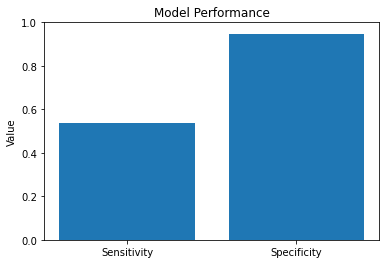

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assume y_true and y_pred are the true and predicted labels, respectively
tn, fp, fn, tp = confusion_matrix(y_dev, y_pred).ravel()

# Compute sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
# print
print("sensitivity: ",sensitivity)
print("specificity:", specificity)
# Visualize the results
fig, ax = plt.subplots()
ax.bar(["Sensitivity", "Specificity"], [sensitivity, specificity])
ax.set_ylim([0, 1])
ax.set_ylabel("Value")
ax.set_title("Model Performance")
plt.show()

In [14]:
# K fold validation test
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# assuming X_resampled_encoded is the one-hot encoded feature matrix
# and y_resampled is the target variable
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=20)

rfc = RandomForestClassifier(n_estimators=100, random_state=20, max_depth = 10)
acc_scores = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_dev)

    acc_score = accuracy_score(y_dev, y_pred)
    print(acc_score)
    acc_scores.append(acc_score)
    tn, fp, fn, tp = confusion_matrix(y_dev, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    # print
    print("sensitivity: ",sensitivity)
    print("specificity:", specificity)
    
    
mean_acc_score = sum(acc_scores) / n_splits
print("Mean accuracy score: ", mean_acc_score)


0.8042553191489362
sensitivity:  0.5740740740740741
specificity: 0.8729281767955801
0.8
sensitivity:  0.5555555555555556
specificity: 0.8729281767955801
0.8085106382978723
sensitivity:  0.5740740740740741
specificity: 0.8784530386740331
0.8042553191489362
sensitivity:  0.5370370370370371
specificity: 0.8839779005524862
0.8085106382978723
sensitivity:  0.5
specificity: 0.9005524861878453
0.8170212765957446
sensitivity:  0.5740740740740741
specificity: 0.8895027624309392
0.8170212765957446
sensitivity:  0.5555555555555556
specificity: 0.8950276243093923
0.7957446808510639
sensitivity:  0.5185185185185185
specificity: 0.8784530386740331
0.8042553191489362
sensitivity:  0.5185185185185185
specificity: 0.8895027624309392
0.8085106382978723
sensitivity:  0.5370370370370371
specificity: 0.8895027624309392
Mean accuracy score:  0.8068085106382978


In [17]:
# XG boosting
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train2, label=y_train2)
dtest = xgb.DMatrix(X_dev, label=y_dev)

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'nthread': 4,
    'seed': 42
}

# Train XGBoost model
num_rounds = 1000
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on test set
y_pred = xgb_model.predict(dtest)

# Convert probabilities to binary predictions
y_pred = [1 if p >= 0.1 else 0 for p in y_pred]

# Evaluate model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("Accuracy: ", accuracy_score(y_dev, y_pred))
print("Precision: ", precision_score(y_dev, y_pred))
print("Recall: ", recall_score(y_dev, y_pred))
print("F1-Score: ", f1_score(y_dev, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_dev, y_pred))


Accuracy:  0.7957446808510639
Precision:  0.5405405405405406
Recall:  0.7407407407407407
F1-Score:  0.625
ROC AUC Score:  0.7764477184366687


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_dev, y_pred)
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print confusion matrix and classification report
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(y_dev, y_pred))

# print sensitivity and specificity
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Confusion matrix:
 [[147  34]
 [ 14  40]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86       181
           1       0.54      0.74      0.62        54

    accuracy                           0.80       235
   macro avg       0.73      0.78      0.74       235
weighted avg       0.83      0.80      0.81       235

Sensitivity: 0.7407407407407407
Specificity: 0.8121546961325967


In [21]:
# K fold validation test
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# assuming X_resampled_encoded is the one-hot encoded feature matrix
# and y_resampled is the target variable
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=20)

rfc = RandomForestClassifier(n_estimators=100, random_state=20, max_depth = 10)
acc_scores = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    dtrain = xgb.DMatrix(X_train2, label=y_train2)
    dtest = xgb.DMatrix(X_dev, label=y_dev)

    # Set XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'eta': 0.3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'nthread': 4,
        'seed': 42
    }

    # Train XGBoost model
    num_rounds = 1000
    xgb_model = xgb.train(params, dtrain, num_rounds)

    # Make predictions on test set
    y_pred = xgb_model.predict(dtest)

    # Convert probabilities to binary predictions
    y_pred = [1 if p >= 0.1 else 0 for p in y_pred]

    acc_score = accuracy_score(y_dev, y_pred)
    print(acc_score)
    acc_scores.append(acc_score)
    tn, fp, fn, tp = confusion_matrix(y_dev, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    # print
    print("sensitivity: ",sensitivity)
    print("specificity:", specificity)
    
    
mean_acc_score = sum(acc_scores) / n_splits
print("Mean accuracy score: ", mean_acc_score)

0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
0.7957446808510639
sensitivity:  0.7407407407407407
specificity: 0.8121546961325967
Mean accuracy score:  0.7957446808510638


In [19]:
# Adaboosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
# Generate some random data for demonstration
# Split data into training and testing sets

# Create an AdaBoost classifier with decision tree as the base estimator
clf = AdaBoostClassifier(n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=2))

# Train the classifier
clf.fit(X_train2, y_train2)

# Make predictions on the test set
y_pred = clf.predict(X_dev)

# Evaluate the performance of the classifier
print(confusion_matrix(y_dev, y_pred))
print(classification_report(y_dev, y_pred))
cm = confusion_matrix(y_dev, y_pred)
tn, fp, fn, tp = cm.ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print confusion matrix and classification report
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(y_dev, y_pred))

# print sensitivity and specificity
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


[[159  22]
 [ 34  20]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       181
           1       0.48      0.37      0.42        54

    accuracy                           0.76       235
   macro avg       0.65      0.62      0.63       235
weighted avg       0.74      0.76      0.75       235

Confusion matrix:
 [[159  22]
 [ 34  20]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       181
           1       0.48      0.37      0.42        54

    accuracy                           0.76       235
   macro avg       0.65      0.62      0.63       235
weighted avg       0.74      0.76      0.75       235

Sensitivity: 0.37037037037037035
Specificity: 0.8784530386740331
